## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [129]:
data = pd.read_csv('data/ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [130]:
# ваш код здесь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [131]:
# ваш код здесь
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.head()
daily_data = data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'users_count',
    'purchase':'purchases_count',
    'price':'price_sum'})
print(f"Group A min date: {daily_data[daily_data['group'] == 'A']['date'].min()}")
print(f"Group B min date: {daily_data[daily_data['group'] == 'B']['date'].min()}")
print('-----------------------------')
print(f"Group A max date: {daily_data[daily_data['group'] == 'A']['date'].max()}")
print(f"Group B max date: {daily_data[daily_data['group'] == 'B']['date'].max()}")

Group A min date: 2021-01-02 00:00:00
Group B min date: 2021-01-02 00:00:00
-----------------------------
Group A max date: 2021-01-24 00:00:00
Group B max date: 2021-01-24 00:00:00


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [132]:
# ваш код здесь
# display(daily_data.head())
users_a = daily_data[daily_data['group']=='A']['users_count'].sum()
users_b = daily_data[daily_data['group']=='B']['users_count'].sum()
purchases_count_a = daily_data[daily_data['group']=='A']['purchases_count'].sum()
purchases_count_b = daily_data[daily_data['group']=='B']['purchases_count'].sum()
price_sum_a = daily_data[daily_data['group']=='A']['price_sum'].sum()
price_sum_b = daily_data[daily_data['group']=='B']['price_sum'].sum()

print(f"Количество посещений сайта в группах А ({users_a}) и B ({users_b})")
print(f"Cуммарное количество покупок в группах А ({purchases_count_a}) и B ({purchases_count_b})")
print(f"Cумма всех покупок (млн. руб.) в группах А ({price_sum_a/1000000}) и B ({price_sum_b/1000000})")


Количество посещений сайта в группах А (147202) и B (147276)
Cуммарное количество покупок в группах А (17723) и B (17514)
Cумма всех покупок (млн. руб.) в группах А (1436.26) и B (1554.1)


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [133]:
# ваш код здесь
user_set_a = set()
user_set_b = set()

for i in range(0, len(data)):
    if data.iloc[i]['group'] == 'A':
        user_set_a.add(data.iloc[i]['user_id'])
    elif data.iloc[i]['group'] == 'B':
        user_set_b.add(data.iloc[i]['user_id'])

print(f"Кол-во уникальных пользователей:\nгруппа А - {len(user_set_a)}\nгруппа В - {len(user_set_b)}")

user_intersection = user_set_a.intersection(user_set_b)
print(f"Кол-во пользователей, которые попали в обе группы - {len(user_intersection)}")


Кол-во уникальных пользователей:
группа А - 146195
группа В - 146284
Кол-во пользователей, которые попали в обе группы - 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [134]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
display(updated_data.head())

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

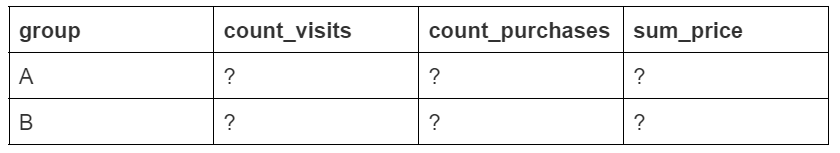
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [135]:
# ваш код здесь
grouped_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'visits_count',
    'purchase':'purchases_count',
    'price':'price_sum'})

display(grouped_data)

,group,visits_count,purchases_count,price_sum
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

<span style=color:blue>**Промежуточные выводы по построенной таблице:**

* qqq
* aaa
* www


## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [136]:
# ваш код здесь
grouped_data['conversion'] = grouped_data['purchases_count'] / grouped_data['visits_count'] * 100
grouped_data['mean_check'] = grouped_data['price_sum'] / grouped_data['purchases_count']
grouped_data.head()

,group,visits_count,purchases_count,price_sum,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

<span style=color:blue>**Промежуточные выводы по таблице grouped_data:**

* qqq
* aaa
* www


## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [137]:
tours_data = updated_data.groupby(['group', 'price']).agg({
    'purchase':'sum'
    }).reset_index().rename(columns={'purchase':'purchases_count'})

display(tours_data)

,group,price,purchases_count
0,A,0,0
1,A,10000,5182
2,A,60000,5271
3,A,100000,1832
4,A,150000,3478
5,A,200000,1724
6,B,0,0
7,B,10000,5201
8,B,60000,1730
9,B,100000,5227


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [138]:
# ваш код здесь

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

<span style=color:blue>**Промежуточные выводы по таблице tours_data:**

* qqq
* aaa
* www

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [139]:
# ваш код здесь
daily_data = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'visits_count',
    'purchase':'purchases_count',
    'price':'price_sum'})

daily_data['conversion'] = daily_data['purchases_count'] / daily_data['visits_count'] * 100
daily_data['mean_check'] = daily_data['price_sum'] / daily_data['purchases_count']

daily_data.head()

,date,group,visits_count,purchases_count,price_sum,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [148]:
# ваш код здесь
# вычисляем кумулятивное количество посещений страницы
daily_data['cum_visits'] = daily_data.groupby(['group'])['visits_count'].cumsum()
# вычисляем кумулятивное количество покупок
daily_data['cum_purchases'] = daily_data.groupby(['group'])['purchases_count'].cumsum()
# вычисляем кумулятивную сумму покупок
daily_data['cum_price'] = daily_data.groupby(['group'])['price_sum'].cumsum()

# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_purchases'] / daily_data['cum_visits'] * 100
# вычисляем кумулятивный средний чек
daily_data['cum_mean_price'] = daily_data['cum_price'] / daily_data['cum_purchases']

display(daily_data[(daily_data['date'] == '2021-01-20') & (daily_data['group'] == 'B')])
display(daily_data[(daily_data['date'] == '2021-01-12') & (daily_data['group'] == 'A')])

,date,group,visits_count,purchases_count,price_sum,conversion,mean_check,cum_visits,cum_purchases,cum_price,cum_conversion,cum_mean_price
37,2021-01-20,B,6685,790,69250000,11.817502,87658.227848,121857,14496,1286900000,11.895911,88776.214128


,date,group,visits_count,purchases_count,price_sum,conversion,mean_check,cum_visits,cum_purchases,cum_price,cum_conversion,cum_mean_price
20,2021-01-12,A,6540,795,68460000,12.155963,86113.207547,68852,8198,668070000,11.906698,81491.827275


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

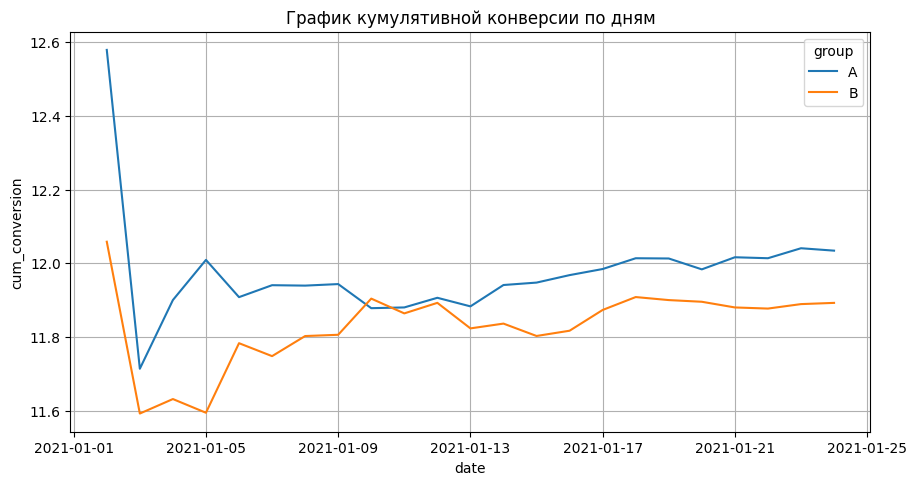

In [149]:
# ваш код здесь
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 0)
# задаём отображение сетки
ax.grid(True);

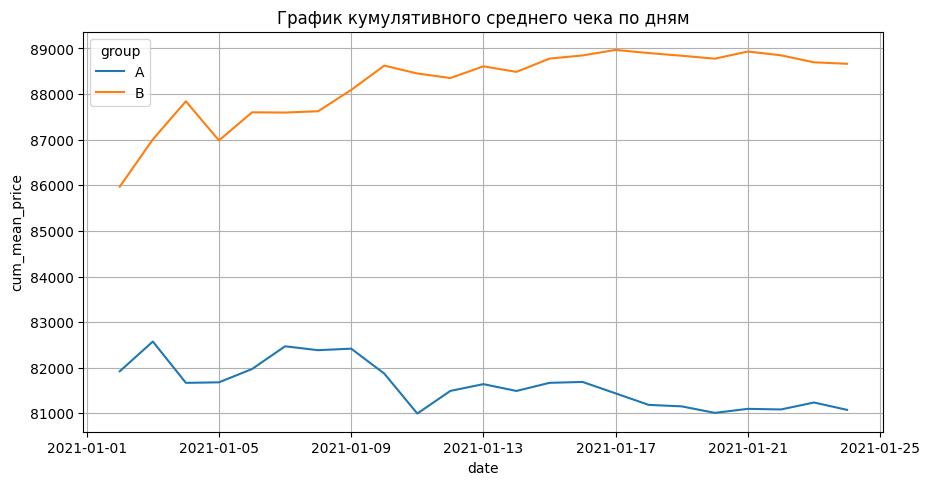

In [150]:
# ваш код здесь
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_price', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 0)
# задаём отображение сетки
ax.grid(True);

<span style=color:blue>**Промежуточные выводы по таблице tours_data:**

* qqq
* aaa
* Начиная с 9 ноября 2020 года конверсии в группах имеют приблизительно идентичное поведение (одинаковые точки роста и спада). При этом конверсия в группе B стабильно выше конверсии в группе A на данном периоде.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [151]:
display(updated_data.head())
converted_piv= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


,sum,count
group,,
A,17487,145307
B,17290,145381


In [152]:
# ваш код здесь
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

<span style=color:blue>**Промежуточные выводы по таблице tours_data:**

* qqq
* aaa

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [157]:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']
display(a_data.head())

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
4,864975,2021-01-21,A,1,150000
5,936923,2021-01-10,A,0,0
7,719014,2021-01-17,A,0,0


In [154]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


In [155]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [158]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [159]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

<span style=color:blue>**Промежуточные выводы по таблице tours_data:**

* qqq
* aaa

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [167]:
# ваш код здесь
#фильтруем данные группы А
a_daily_data = daily_data[daily_data['group'] == 'A']['mean_check']
#фильтруем данные группы B
b_daily_data = daily_data[daily_data['group'] == 'B']['mean_check']

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

_, p = shapiro(a_daily_data)
print('p=%.3f' % p)
# Интерпретация 
if p > alpha:
	print(H0, '(Группа A)')
else:
	print(Ha, '(Группа A)')

_, p = shapiro(b_daily_data)
print('p=%.3f' % p)
# Интерпретация 
if p > alpha:
	print(H0, '(Группа B)')
else:
	print(Ha, '(Группа B)')

p=0.253
Данные распределены нормально (Группа A)
p=0.094
Данные распределены нормально (Группа B)


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

Выбираем **сравнительный** тест по метрике среднего чека:

Данные распределены по нормальному закону: *Да* -> **Параметрический тест** -> Тип зависимой переменной (средний чек): *Количественная* -> **Тест на сравнение выборки** -> Сколько групп сравнивается (А и В): *2* -> Сколько объектов в выборке (22 дня ): *<30* -> ***Независимый Т-тест***

In [168]:
# ваш код здесь
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок используя отфильтрованные данные ро группам из Задания 7.12
results = ttest_ind(
    a=a_daily_data,
    b=b_daily_data, 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

<span style=color:blue>**Промежуточные выводы по таблице tours_data:**

* qqq
* aaa

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 